# Analyse ROMY Events

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees import sixdegrees

## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time
    
    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': "XX.ROMY..BJ*", # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': "XX.ROMY..BH*",  # Translation sensor seed ID
    
    # Data source
    'data_source': "mseed_file",  # "fdsn" | "sds" | "mseed_file"
    'fdsn_client_rot': None,  # "IRIS",
    'fdsn_client_tra': None,  # "IRIS",

    # Path to SDS for rotation and translation data
    'path_to_sds_rot': "/home/andbro/freenas/temp_archive/",    # SDS path for rotation data
    'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    'path_to_inv_rot': "/home/andbro/kilauea-data/stationxml_ringlaser/station_BW_ROMY.xml",  # Rotation station inventory
    'path_to_inv_tra': "/home/andbro/kilauea-data/stationxml_ringlaser/station_GR_FUR.xml",  # Translation station inventory
    
    # Path to local mseed file
    'path_to_mseed_file': "./data/romy_eventM6.8.mseed",  # "./data/eventM62_6c.mseed",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "ROMY_Analysis",  # Project name
    
    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'time_win_sec': 30,          # Window length in seconds
    'time_win_sec_overlap': 15,  # Window overlap in seconds
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Setup a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

Get key information about the event

In [5]:
ev = sd.get_event_info(origin_time=config['origin_time'],
                       base_catalog="USGS",
                       magnitude=config['magnitude'])

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Distance: 22.7°
Backazimuth: 228.4°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [6]:
sd.load_data(config['tbeg'], config['tend'])

3 Trace(s) in Stream:
XX.ROMY..BHE | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.940000Z | 20.0 Hz, 56440 samples
XX.ROMY..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.940000Z | 20.0 Hz, 56440 samples
XX.ROMY..BHZ | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.939999Z | 20.0 Hz, 56440 samples
-> removing no response
-> removing no response
3 Trace(s) in Stream:
XX.ROMY..BJE | 2023-09-08T22:12:59.036600Z - 2023-09-08T23:00:00.986600Z | 20.0 Hz, 56440 samples
XX.ROMY..BJN | 2023-09-08T22:12:58.999400Z - 2023-09-08T23:00:00.949400Z | 20.0 Hz, 56440 samples
XX.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:00.961600Z | 20.0 Hz, 56440 samples


Ensure that all traces of stream have the same sample size

In [7]:
sd.trim_stream(set_common=True, set_interpolate=False)

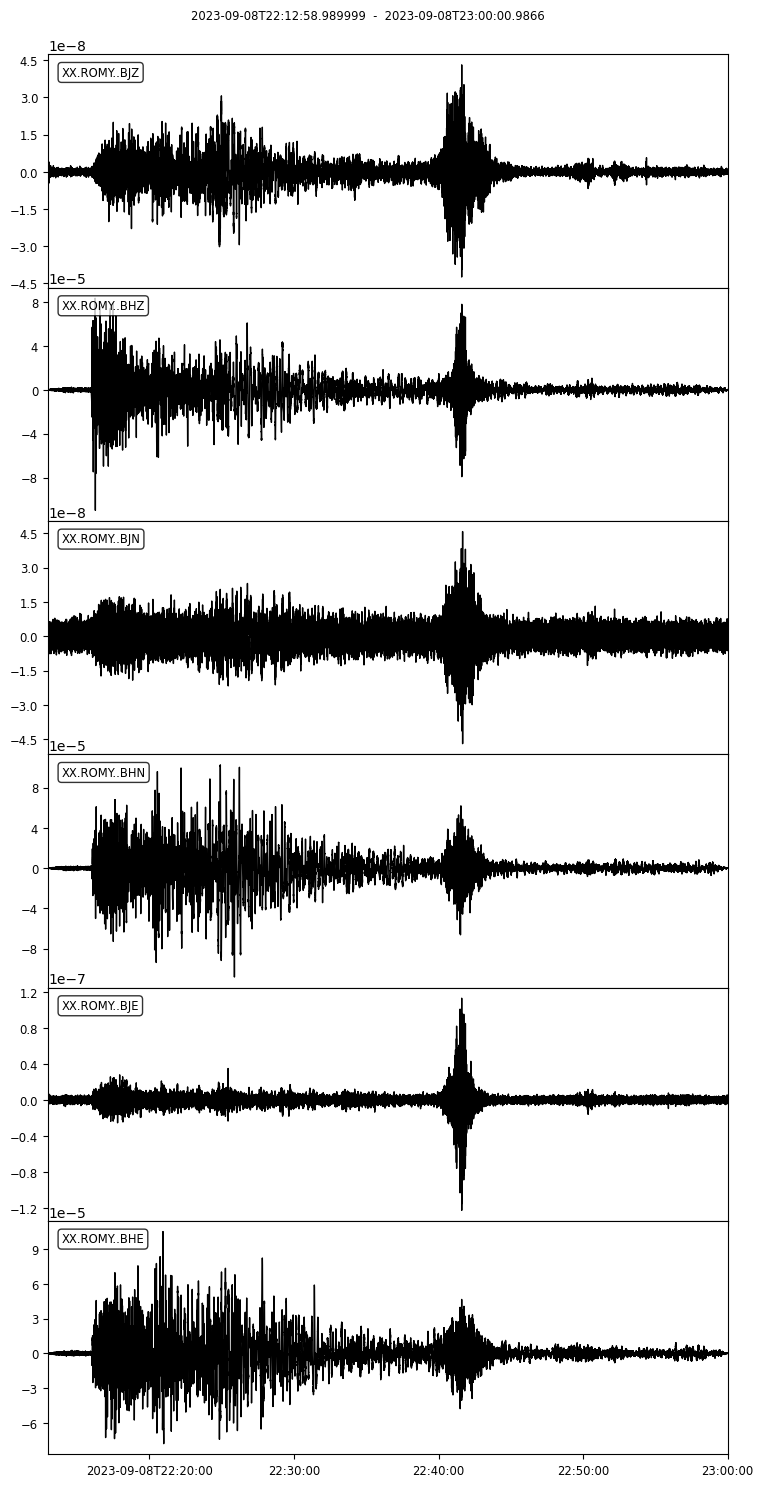

In [8]:
sd.st.plot(equal_scale=False);

### Only required for time lag correction

In [9]:
# #finde (and correct) time lag between translation and rotation data
# sd.get_component_lag(normalize=True,
#                      baz=ev['backazimuth'],
#                      correct=True)

# # update endtime
# sd.tend = sd.tbeg+25

# # trim stream
# sd.st = sd.st.trim(sd.tbeg, sd.tend)

# sd.st.plot(equal_scale=False);

### Write data to file or SDS system

In [10]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

In [11]:
sd.get_theoretical_arrival(phase='p')

No theoretical arrivals found for phase p


### Wavelet Comparsion

/home/andbro/cursorfiles/BSPF/sixdegrees.py:2352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


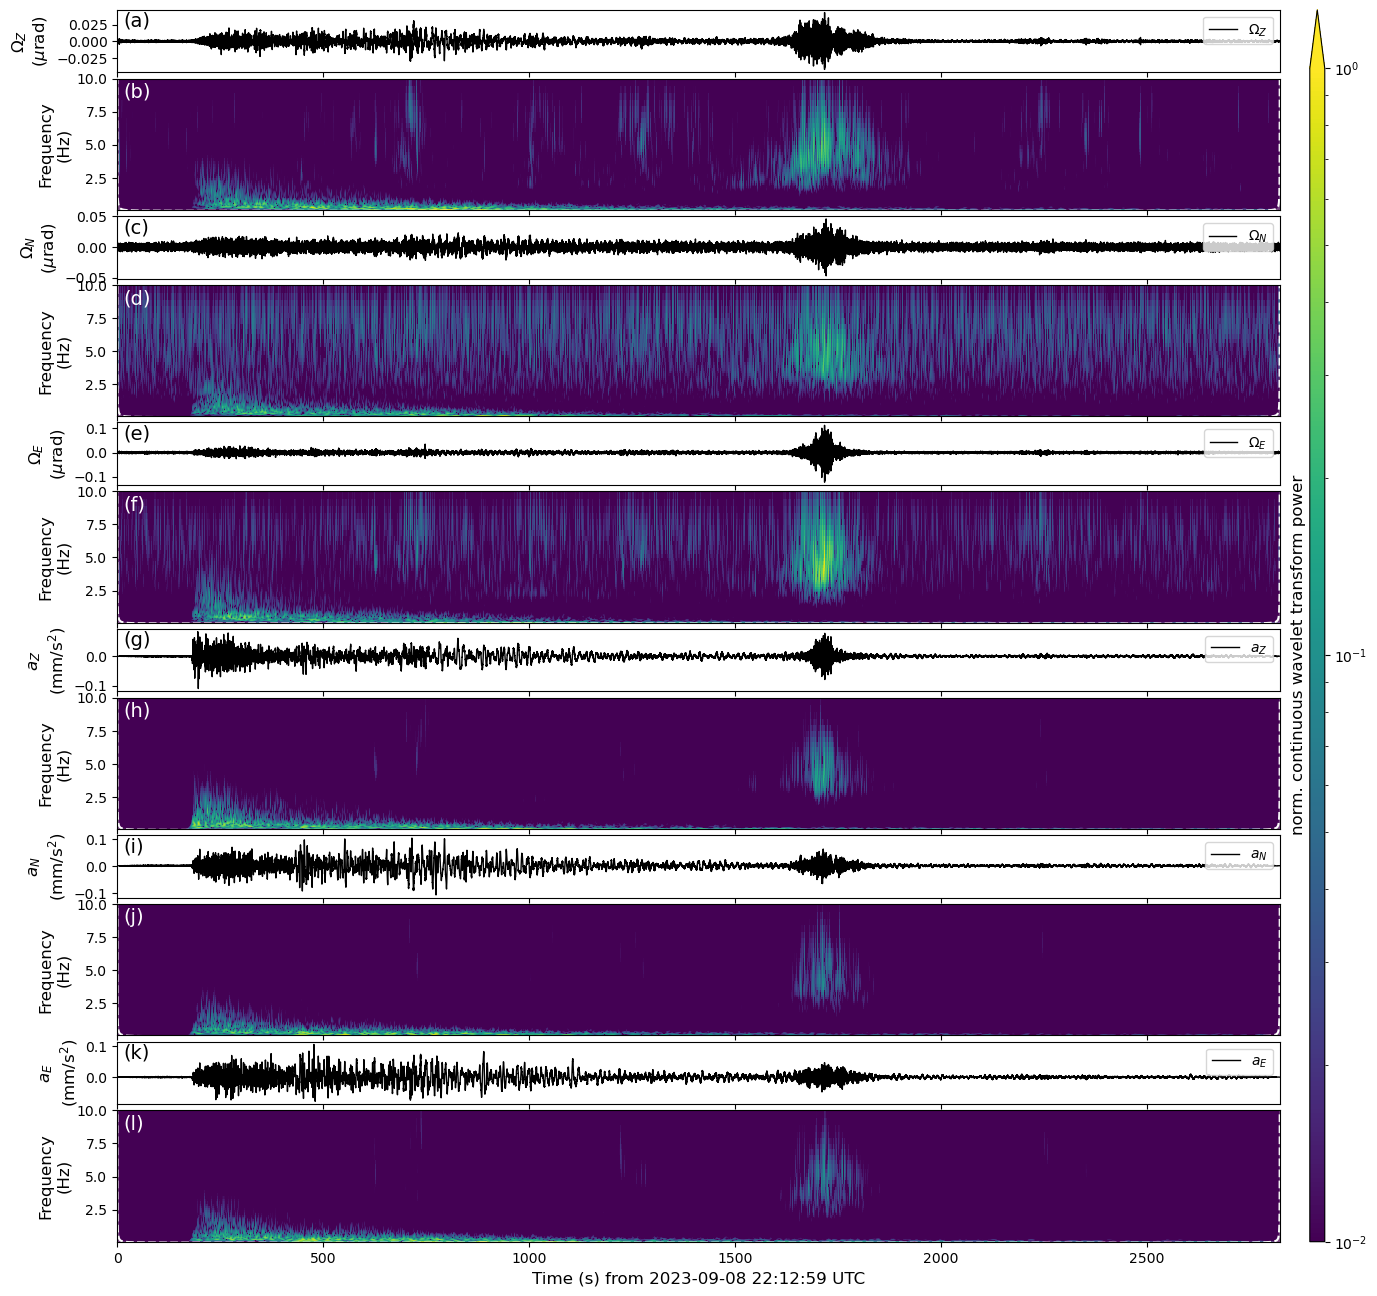

In [12]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:
    # Rotation components
    rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
    cwt_results[f"{comp}_Rotation"] = sixdegrees.compute_cwt(
        rot_data.times(), rot_data.data, rot_data.stats.delta,
        normalize=True
    )
    
    # Translation components
    acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
    cwt_results[f"{comp}_Translation"] = sixdegrees.compute_cwt(
        acc_data.times(), acc_data.data, acc_data.stats.delta,
        normalize=True
    )

# Then plot all components
fig = sixdegrees.plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=10
)

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [13]:
sd.filter_data(fmin=0.02, fmax=0.2, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [14]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

let's compare the waveforms of the rotation (red) and translational (black) components 

In [15]:
# fig = sd.plot_waveform_cc(rot0=sd.get_stream("rotation"),
#                         acc0=sd.get_stream("translation"),
#                         baz=ev['backazimuth'],
#                         distance=ev['distance_km'],
#                         fmin=sd.fmin, fmax=sd.fmax, 
#                         twin_sec=20, twin_overlap=0.5,
#                         )

In [16]:
# fig = sd.plot_spectra_comparison_fill(rot=sd.get_stream("rotation"), 
#                                       acc=sd.get_stream("translation"),
#                                       fmin=0.09, fmax=0.6,
#                                       ylog=False, xlog=False, fill=True
#                                       )

### Backazimuth Estimate

In [17]:
# # First compute backazimuth
# baz_results = sd.compute_backazimuth(
#     wave_type='love',
#     baz_step=1,
#     baz_win_sec=20,
#     baz_win_sec_overlap=0.5,
#     out=True
# )

# # Then plot results
# fig = sd.plot_backazimuth_results(
#     baz_results,
#     wave_type='love',
#     baz_theo=ev['backazimuth'],
#     cc_threshold=0.5,  # optional
# )

In [18]:
# # First compute backazimuth
# baz_results = sd.compute_backazimuth(
#     wave_type='rayleigh',
#     baz_step=1,
#     baz_win_sec=20,
#     baz_win_sec_overlap=0.5,
#     out=True
# )

# # # Then plot results
# fig = sd.plot_backazimuth_results(
#     baz_results,
#     wave_type='rayleigh',
#     baz_theo=ev['backazimuth'],
#     cc_threshold=0.5,  # optional
# )

In [19]:
# fig, results = sd.compare_backazimuth_methods(
#     Twin=20.0,
#     Toverlap=0.5,
#     invert_rot_z=False,
#     invert_acc_z=False,
#     cc_threshold=0.1,
#     baz_theo=ev['backazimuth'],
#     plot=True,
#     output=True
# )

### Analyse phase velocities

In [20]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [21]:
# # Plot results
# fig = sd.plot_velocities(
#     velocity_results=love_velocities,
#     vmax=5000,  # optional
#     minors=True # optional
# )

# # Plot results
# fig = sd.plot_velocities(
#     velocity_results=rayleigh_velocities,
#     vmax=5000,  # optional
#     minors=True # optional
# )

In [22]:
results =sd.compute_velocities_in_windows(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

### Compare RANSAC and ODR

In [23]:
# # Compute Love wave velocities
# love_velocities_ransac = sd.compute_velocities(
#     wave_type='love',
#     win_time_s=20.0,
#     overlap=0.5,
#     cc_threshold=0.5,
#     method='ransac',
#     baz=ev['backazimuth']  # optional
# )

# # Compute Rayleigh wave velocities
# rayleigh_velocities_ransac = sd.compute_velocities(
#     wave_type='rayleigh',
#     win_time_s=20.0,
#     overlap=0.5,
#     cc_threshold=0.5,
#     method='ransac',
#     baz=ev['backazimuth']  # optional
# )

# # Compute Love wave velocities
# love_velocities_odr = sd.compute_velocities(
#     wave_type='love',
#     win_time_s=20.0,
#     overlap=0.5,
#     cc_threshold=0.7,
#     method='odr',
#     baz=ev['backazimuth']  # optional
# )

# # Compute Rayleigh wave velocities
# rayleigh_velocities_odr = sd.compute_velocities(
#     wave_type='rayleigh',
#     win_time_s=20.0,
#     overlap=0.5,
#     cc_threshold=0.7,
#     method='odr',
#     baz=ev['backazimuth']  # optional
# )

In [24]:
# import matplotlib.pyplot as plt

# # Create comparison plot
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# cc_threshold = 0.5
# mask = love_velocities_ransac['ccoef'] >= cc_threshold

# # Plot velocities vs time
# ax1.scatter(love_velocities_ransac['time'][mask],
#             love_velocities_ransac['velocity'][mask],
#            c=love_velocities_ransac['ccoef'][mask]  ,
#            cmap='viridis', vmin=0, vmax=1, label='RANSAC', alpha=0.9)

# ax2.scatter(love_velocities_odr['time'][mask]   ,
#             love_velocities_odr['velocity'][mask],
#            c=love_velocities_odr['ccoef'][mask],
#            cmap='viridis', vmin=0, vmax=1, label='ODR', alpha=0.9)

# ax3.scatter(love_velocities_odr['time'][mask],
#             love_velocities_odr['velocity'][mask] - love_velocities_ransac['velocity'][mask],
#             label='ODR - RANSAC', alpha=0.9, color='black')

# # Configure axes
# for ax in [ax1, ax2, ax3]:
#     ax.set_ylabel('Velocity (m/s)')
#     ax.grid(which='both', zorder=0, alpha=0.5)
#     ax.legend()
#     ax.minorticks_on()

# plt.suptitle('Love Wave Velocity Estimates: RANSAC vs ODR')
# plt.tight_layout()

In [25]:
# love_velocities_win = sd.compute_velocities_in_windows(
#     wave_type="love",
#     win_time_s=20,
#     overlap=0.5,
#     cc_threshold=0.5,
#     adjusted_baz=True,
#     baz=0,
#     method='odr'
# )

# rayleigh_velocities_win = sd.compute_velocities_in_windows(
#     wave_type="rayleigh",
#     win_time_s=20,
#     overlap=0.5,
#     cc_threshold=0.5,
#     adjusted_baz=True,
#     baz=0,
#     method='odr'
# )

In [26]:
# def plot_love_velocities_win(results_velocities, cc_threshold=0.0):

#     from numpy import array

#     # Convert arrays if needed
#     times = array(results_velocities['time'])
#     baz = array(results_velocities['backazimuth'])
#     vel = array(results_velocities['velocity'])
#     cc = array(results_velocities['ccoef'])

#     # apply threshold
#     mask = cc >= cc_threshold

#     # Create figure with space for colorbar
#     fig = plt.figure(figsize=(12, 8))
#     gs = fig.add_gridspec(2, 2, width_ratios=[15, 0.5], hspace=0.1)

#     # Create subplots
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
#     cax = fig.add_subplot(gs[:, 1])  # colorbar axis

#     # Plot backazimuth estimates
#     sc1 = ax1.scatter(results_velocities['time'][mask], results_velocities['backazimuth'][mask], 
#                     c=results_velocities['ccoef'][mask], cmap='viridis', 
#                     alpha=1, label='Estimated BAZ', zorder=2, vmin=0, vmax=1)
#     ax1.axhline(y=ev['backazimuth'], color='r', ls='--', label='Theoretical BAZ', zorder=0)

#     # Plot velocity estimates
#     sc2 = ax2.scatter(results_velocities['time'][mask], results_velocities['velocity'][mask], 
#                     c=results_velocities['ccoef'][mask], cmap='viridis', 
#                     alpha=1, label='Phase Velocity', zorder=2, vmin=0, vmax=1)

#     # Configure axes
#     ax1.set_ylabel('Backazimuth (°)')
#     ax1.grid(which='both', zorder=0, alpha=0.5)
#     ax1.legend()

#     ax2.set_ylim(0, 5000)
#     ax2.set_xlabel('Time (s)')
#     ax2.set_ylabel('Velocity (m/s)')
#     ax2.grid(which='both', zorder=0, alpha=0.5)
#     ax2.legend()

#     for a in [ax1, ax2]:
#         a.minorticks_on()

#     # Add colorbar
#     cb = plt.colorbar(sc1, cax=cax, label='Cross-Correlation Coefficient')

#     # title = f'{results_velocities["parameters"]["wave_type"].upper()} Wave Analysis'
#     # plt.suptitle(title, y=0.91)

#     plt.tight_layout()
#     return fig

# fig = plot_love_velocities_win(love_velocities_win,cc_threshold=0.7)

# fig = plot_love_velocities_win(rayleigh_velocities_win,cc_threshold=0.7)

### Test optimization of parameters with frequency and backazimuth in time windows


Optimal Parameters (v ≤ {vel_max_threshold} m/s):
Mean Velocity: 932.0 m/s
Mean Backazimuth: 245.0°
Mean Cross-correlation: 0.876
Number of points: 102 / 134


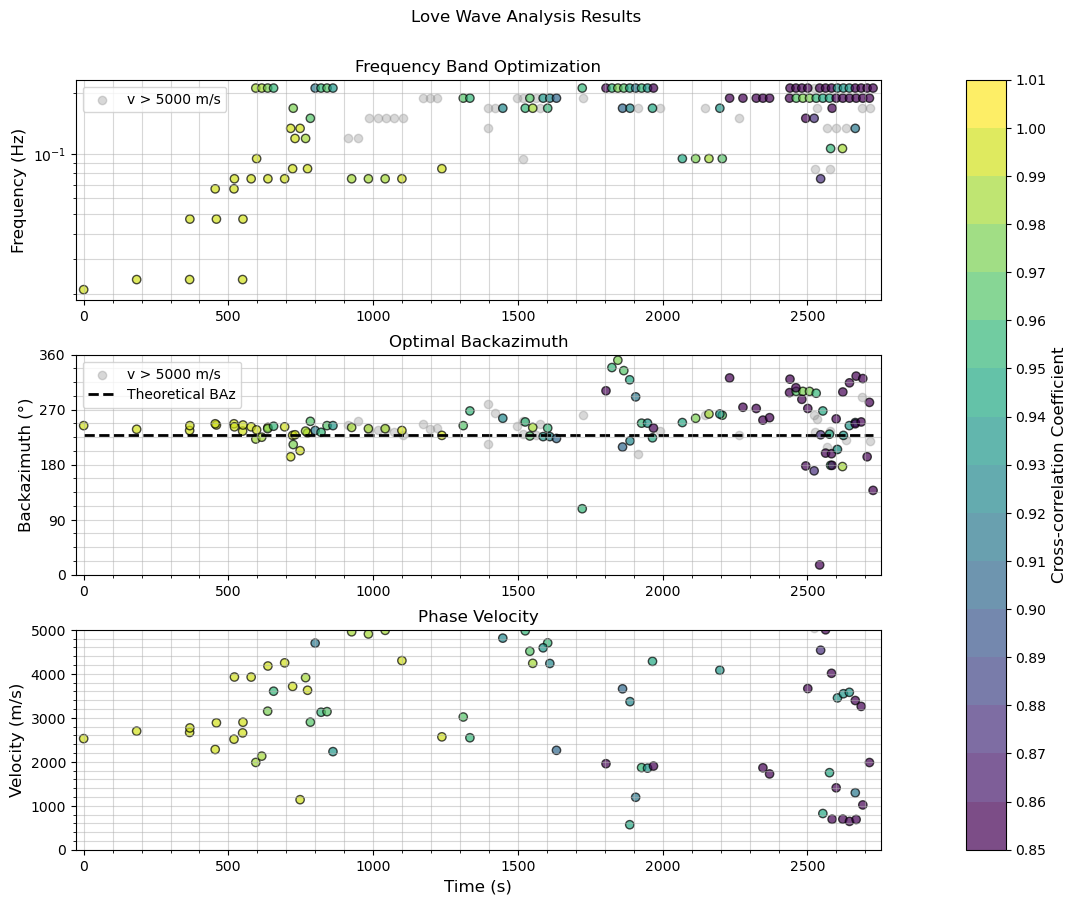

In [34]:
# Get optimization results
params = sd.optimize_parameters(wave_type='love', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
                              baz_step=1,
                              twin_min=10,
                              overlap=0.75,
                              bandwidth_factor=2)

# Plot results using the class method
fig = sd.plot_optimization_results(params, wave_type='love',
                                   vel_max_threshold=5000,
                                   cc_threshold=0.85,
                                   baz_theo=ev['backazimuth'])
plt.show()


Optimal Parameters (v ≤ {vel_max_threshold} m/s):
Mean Velocity: 6.2 m/s
Mean Backazimuth: 231.2°
Mean Cross-correlation: 0.832
Number of points: 43 / 134


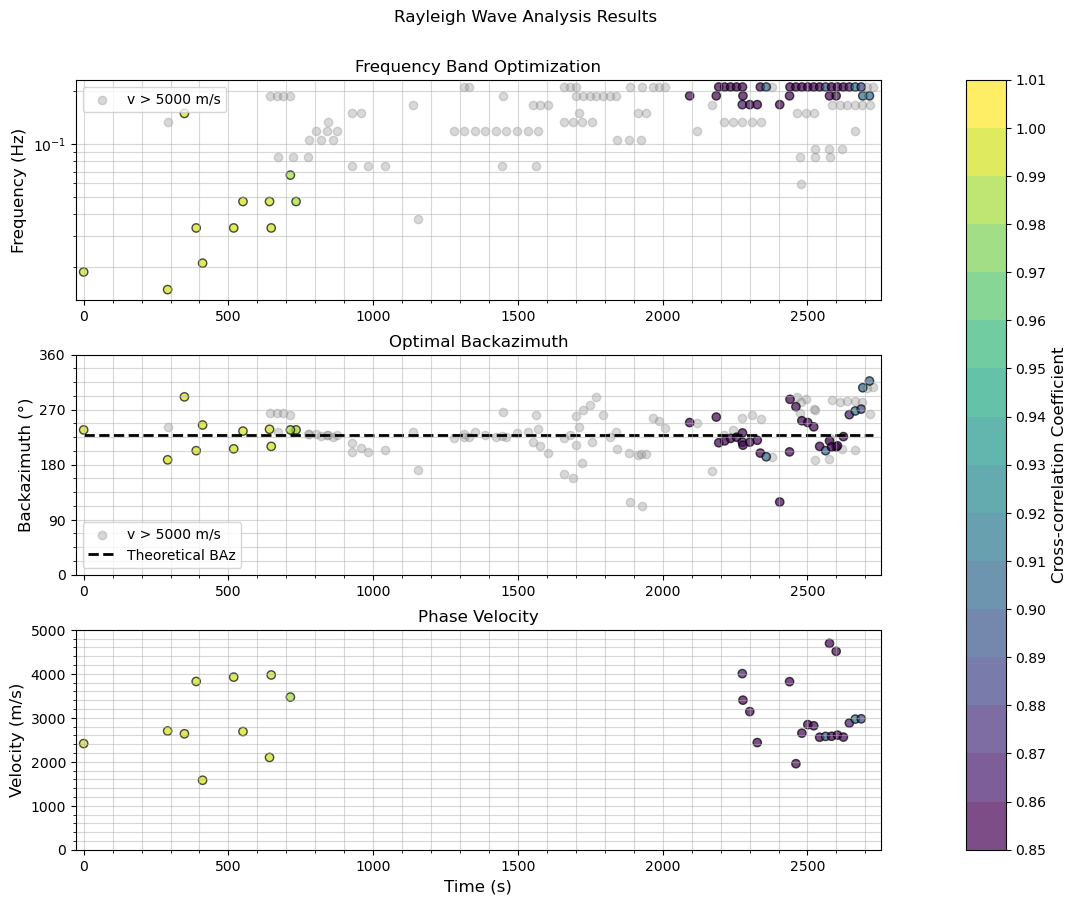

In [35]:
# Get optimization results
params = sd.optimize_parameters(wave_type='rayleigh', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
                              baz_step=1,
                              twin_min=10,
                              overlap=0.75,
                              bandwidth_factor=2)

# Plot results using the class method
fig = sd.plot_optimization_results(params, wave_type='rayleigh',
                                   vel_max_threshold=5000,
                                   cc_threshold=0.85,
                                   baz_theo=ev['backazimuth'])
plt.show()

In [29]:
# def plot_optimization_results(params, wave_type='love', vel_max_threshold=5000):
#     """
#     Plot optimization results including frequency bands, backazimuth, and velocities
#     """
#     import numpy as np
#     import matplotlib.pyplot as plt
#     from matplotlib.gridspec import GridSpec
#     from matplotlib.colors import BoundaryNorm, ListedColormap
    
#     font = 12

#     # Create figure
#     fig = plt.figure(figsize=(12, 10))
#     gs = GridSpec(3, 2, figure=fig, 
#                  width_ratios=[1, 0.05], 
#                  height_ratios=[1, 1, 1], 
#                  hspace=0.25)
    
#     # Convert data to arrays if needed
#     times = np.array(params['times'])
#     freqs = np.array(params['frequency']['center'])
#     baz = np.array(params['backazimuth']['optimal'])
#     vel = np.array(params['velocity'])
#     cc = np.array(params['cross_correlation']['optimal'])
    
#     # Create velocity mask
#     vel_mask = vel <= vel_max_threshold
    
#     # Set colorbar parameters
#     vmin, vmax, vstep = 0.9, 1.0, 0.01
#     levels = np.arange(vmin, vmax + vstep, vstep)  # steps of 0.01
    
#     # Create discrete colormap
#     n_bins = len(levels) - 1
#     viridis = plt.cm.get_cmap('viridis')
#     colors = viridis(np.linspace(0, 1, n_bins))
#     cmap = ListedColormap(colors)
#     norm = BoundaryNorm(levels, ncolors=len(levels)-1)
    
#     # 1. Plot frequency band optimization
#     ax1 = fig.add_subplot(gs[0, 0])
#     # Plot grey dots for values above threshold
#     ax1.scatter(times[~vel_mask], freqs[~vel_mask], 
#                 color='grey', alpha=0.3, label=f'v > {vel_max_threshold} m/s')
#     # Plot colored dots for values below threshold
#     sc1 = ax1.scatter(times[vel_mask], freqs[vel_mask], 
#                      c=cc[vel_mask], cmap=cmap, alpha=0.7,
#                      norm=norm, edgecolor='black')
#     ax1.set_ylabel('Frequency (Hz)', fontsize=font)
#     ax1.set_yscale('log')
#     ax1.set_title('Frequency Band Optimization', fontsize=font)
#     ax1.grid(which='both', zorder=0, alpha=0.5)
#     ax1.legend()
#     ax1.set_ylim(freqs.min(), freqs.max())
    
#     # 2. Plot backazimuth results
#     ax2 = fig.add_subplot(gs[1, 0])
#     # Plot grey dots for values above threshold
#     ax2.scatter(times[~vel_mask], baz[~vel_mask], 
#                 color='grey', alpha=0.3, label=f'v > {vel_max_threshold} m/s')
#     # Plot colored dots for values below threshold
#     sc2 = ax2.scatter(times[vel_mask], baz[vel_mask],
#                      c=cc[vel_mask], cmap=cmap, alpha=0.7,
#                      norm=norm, edgecolor='black')
#     ax2.set_ylabel('Backazimuth (°)', fontsize=font)
#     ax2.grid(which='both', zorder=0, alpha=0.5)
#     ax2.legend()
#     ax2.set_title('Optimal Backazimuth', fontsize=font)
#     ax2.set_ylim(0, 360)

#     ax2.set_yticks([0, 90, 180, 270, 360])
#     ax2.set_yticklabels(['0', '90', '180', '270', '360'])

#     # 3. Plot velocity results
#     ax3 = fig.add_subplot(gs[2, 0])
#     # Plot grey dots for values above threshold
#     ax3.scatter(times[~vel_mask], vel[~vel_mask], 
#                 color='grey', alpha=0.3)
#     # Plot colored dots for values below threshold
#     sc3 = ax3.scatter(times[vel_mask], vel[vel_mask],
#                      c=cc[vel_mask], cmap=cmap, alpha=0.7,
#                      norm=norm, edgecolor='black')
#     ax3.set_xlabel('Time (s)', fontsize=font)
#     ax3.set_ylabel('Velocity (m/s)', fontsize=font)
#     ax3.grid(which='both', zorder=0, alpha=0.5)
#     ax3.set_title('Phase Velocity', fontsize=font)
#     ax3.set_ylim(0, vel_max_threshold)
    
#     for ax in [ax1, ax2, ax3]:
#         ax.minorticks_on()
#         ax.set_xlim(times.min()-0.01*times.max(), times.max()+0.01*times.max())
    
#     # Add vertical colorbar
#     cax = fig.add_subplot(gs[:, 1])
#     cbar = plt.colorbar(sc3, cax=cax,
#                        ticks=levels)
#     cbar.set_label('Cross-correlation Coefficient', fontsize=font)
    
#     plt.suptitle(f'{wave_type.capitalize()} Wave Analysis Results', y=0.95)
#     plt.tight_layout()
    
#     # Print statistics for values below threshold
#     print("\nOptimal Parameters (v ≤ {vel_threshold} m/s):")
#     print(f"Mean Velocity: {np.nanmean(vel[vel_mask]):.1f} m/s")
#     print(f"Mean Backazimuth: {np.nanmean(baz[vel_mask]):.1f}°")
#     print(f"Mean Cross-correlation: {np.nanmean(cc[vel_mask]):.3f}")
#     print(f"Number of points: {np.sum(vel_mask)} / {len(vel_mask)}")
    
#     return fig

# # Usage:
# fig = plot_optimization_results(params, wave_type='love', vel_max_threshold=5000)
# plt.show()